In [1]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.base import TransformerMixin
import jellyfish as jf
from multiprocessing import Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import unicodedata
import tensorflow as tf
from scipy.sparse import csr_matrix
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,make_scorer,recall_score)
from sklearn.model_selection import (train_test_split, RepeatedKFold, RepeatedStratifiedKFold,
                                     cross_validate, cross_val_score, KFold)
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

2023-11-01 22:55:38.461116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 22:55:38.747821: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 22:55:38.749344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 22:55:40.083835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [266]:
def get_cv_scores_report_classification(estimator, X, y, n_splits):
    cv_scores = cross_validate(
                    estimator = estimator,
                    X         = X,
                    y         = y,
                    scoring   = 'accuracy',
                    cv        = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=5, random_state=333),
                )
    
    accuracy_scores = cv_scores['test_score']
    mean_accuracy = accuracy_scores.mean()
    std_accuracy = accuracy_scores.std()
    
    print(f"Accuracy: {mean_accuracy:.4f} (+/- {2*std_accuracy:.4f})")

def clean_text(text, pattern="[^a-zA-Z0-9]"):
    if isinstance(text, str):
        cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
        cleaned_text = re.sub(pattern, " ", cleaned_text.decode("ascii"), flags=re.UNICODE)
        cleaned_text = u' '.join(cleaned_text.lower().lstrip().strip().split())
    else:
        cleaned_text = text
    return cleaned_text

In [706]:
genero = pd.read_csv('song_genres.csv')


In [707]:
genero['main_genre'].value_counts()

main_genre
Rock          3413
Electronic     998
Pop            596
Jazz           566
Metal          449
RnB            444
Rap            431
Country        365
Reggae         323
Blues          263
Folk           202
Punk           127
Latin          120
World           70
New Age         49
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Rock'),
  Text(1, 0, 'Electronic'),
  Text(2, 0, 'Pop'),
  Text(3, 0, 'Jazz'),
  Text(4, 0, 'Metal'),
  Text(5, 0, 'RnB'),
  Text(6, 0, 'Rap'),
  Text(7, 0, 'Country'),
  Text(8, 0, 'Reggae'),
  Text(9, 0, 'Blues'),
  Text(10, 0, 'Folk'),
  Text(11, 0, 'Punk'),
  Text(12, 0, 'Latin'),
  Text(13, 0, 'World'),
  Text(14, 0, 'New Age')])

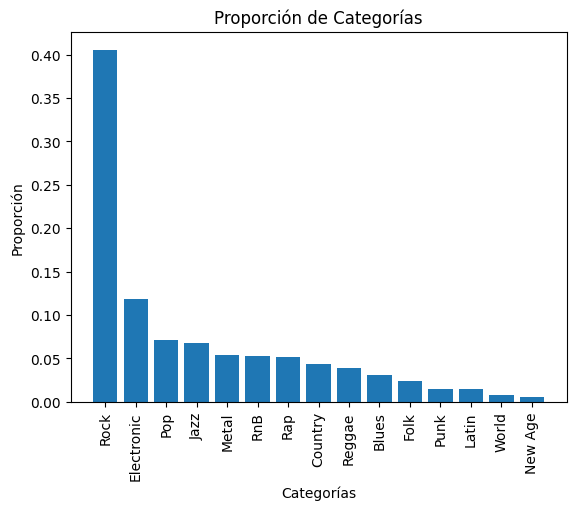

In [708]:
proporciones = genero['main_genre'].value_counts(normalize=True)

plt.bar(proporciones.index, proporciones.values)
plt.title('Proporción de Categorías')
plt.xlabel('Categorías')
plt.ylabel('Proporción')
plt.xticks(rotation=90)

In [709]:
summary = pd.read_csv('summary.csv')
features = pd.read_csv('audio_features.csv')



In [755]:
df = genero.merge(summary[['track_id','energy','year','duration','tempo','loudness']],on = 'track_id', how ='inner')
df = df.merge(features[['track_id',"danceability","femaleness","aggressiveness","electronicity","happiness","festiveness","relaxation","sadness",
    "brightness","tonality","insrumentalness"]], on = 'track_id' , how  = 'inner')

In [756]:
df = df.set_index('track_id')

In [712]:
df

,main_genre,energy,year,duration,tempo,loudness,danceability,femaleness,aggressiveness,electronicity,happiness,festiveness,relaxation,sadness,brightness,tonality,insrumentalness
track_id,,,,,,,,,,,,,,,,,
TRIZJQX128F1472163,Folk,0.0,1988,294.79138,128.077,-10.063,0.738876,0.115795,0.977232,0.826606,0.238988,0.507743,0.009022,0.027817,0.631508,0.189532,0.320533
TRICGTU128F1495593,Rock,0.0,2004,406.15138,134.082,-4.624,0.008645,0.581509,0.999336,0.757660,0.363568,0.871779,0.052387,0.009525,0.079771,0.018337,0.000999
TRRVWDU128F92E22B8,Rock,0.0,1972,269.26975,142.413,-7.508,0.093345,0.415226,0.652252,0.331811,0.262383,0.423110,0.040753,0.040539,0.340711,0.984945,0.002083
TRRZSST128F92D2F9B,Rock,0.0,1981,272.37832,93.009,-13.419,0.927335,0.415502,0.012299,0.104439,0.584595,0.061626,0.961521,0.668766,0.155453,0.932320,0.005253
TRLPKDE128F1468DF1,World,0.0,1994,405.68118,162.467,-15.558,0.067613,0.958484,0.000003,0.023576,0.131362,0.026085,0.817858,0.934048,0.856091,0.641538,0.004622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRSHZPG128F145C166,Rock,0.0,1995,186.53995,159.963,-10.399,0.010185,0.103583,0.998675,0.247002,0.737138,0.537053,0.055443,0.030870,0.219793,0.697471,0.000182
TRHULEA128F4277158,Rock,0.0,1986,161.41016,184.628,-7.599,0.971773,0.485036,0.973640,0.118858,0.332644,0.527728,0.056056,0.140389,0.983308,0.985111,0.003687
TRGIYIR128F92DCDF1,Rock,0.0,2008,376.63302,129.997,-5.848,0.620751,0.223400,0.202690,0.386255,0.021479,0.583628,0.784461,0.635575,0.789153,0.858578,0.838124


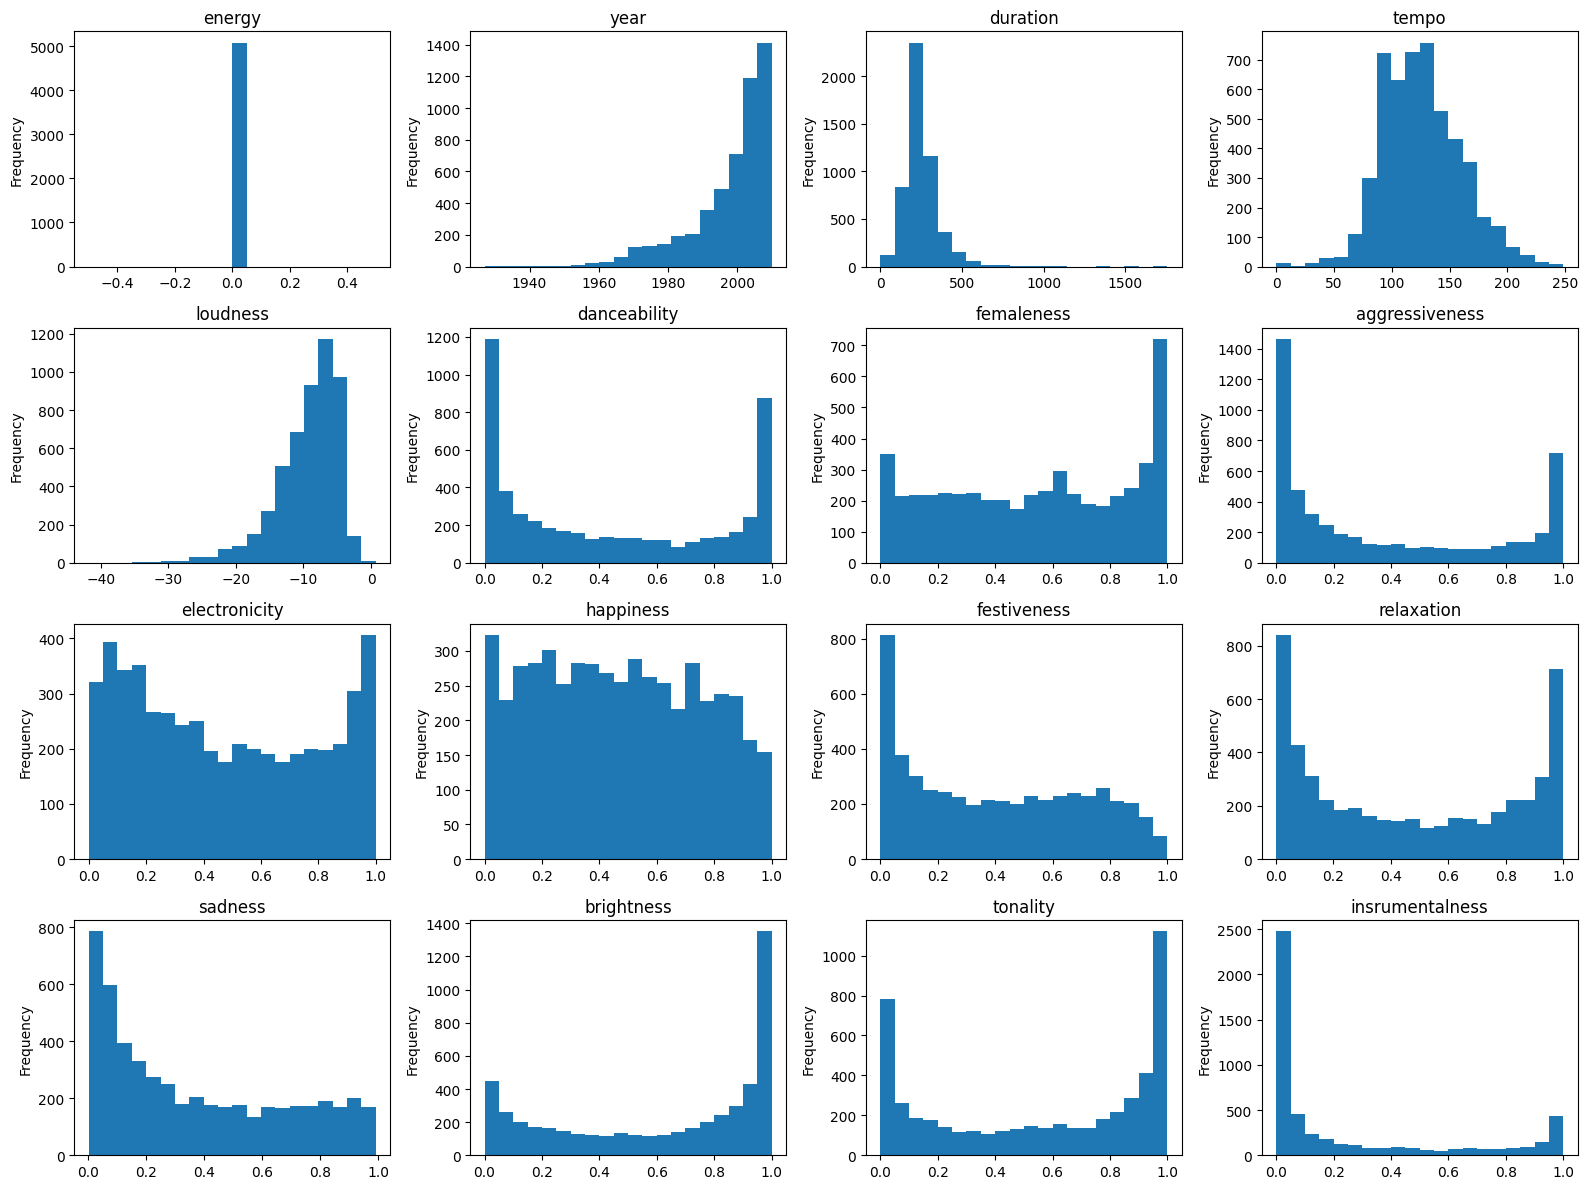

In [713]:
numerical_features = ['energy', 'year', 'duration', 'tempo', 'loudness', 'danceability', 'femaleness', 'aggressiveness', 'electronicity', 'happiness', 'festiveness', 'relaxation', 'sadness', 'brightness', 'tonality', 'insrumentalness']

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))

for i, feature in enumerate(numerical_features):
    row, col = i // 4, i % 4
    df[feature].plot(kind='hist', bins=20, ax=axes[row, col])
    axes[row, col].set_title(feature)
    
plt.tight_layout()
plt.show()

In [757]:
df = df.drop('energy', axis =1 )

In [758]:
df = df.drop('year', axis =1 )

In [716]:
df.isnull().sum(axis = 0)

main_genre         0
duration           0
tempo              0
loudness           0
danceability       0
femaleness         0
aggressiveness     0
electronicity      0
happiness          0
festiveness        0
relaxation         0
sadness            0
brightness         0
tonality           0
insrumentalness    0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

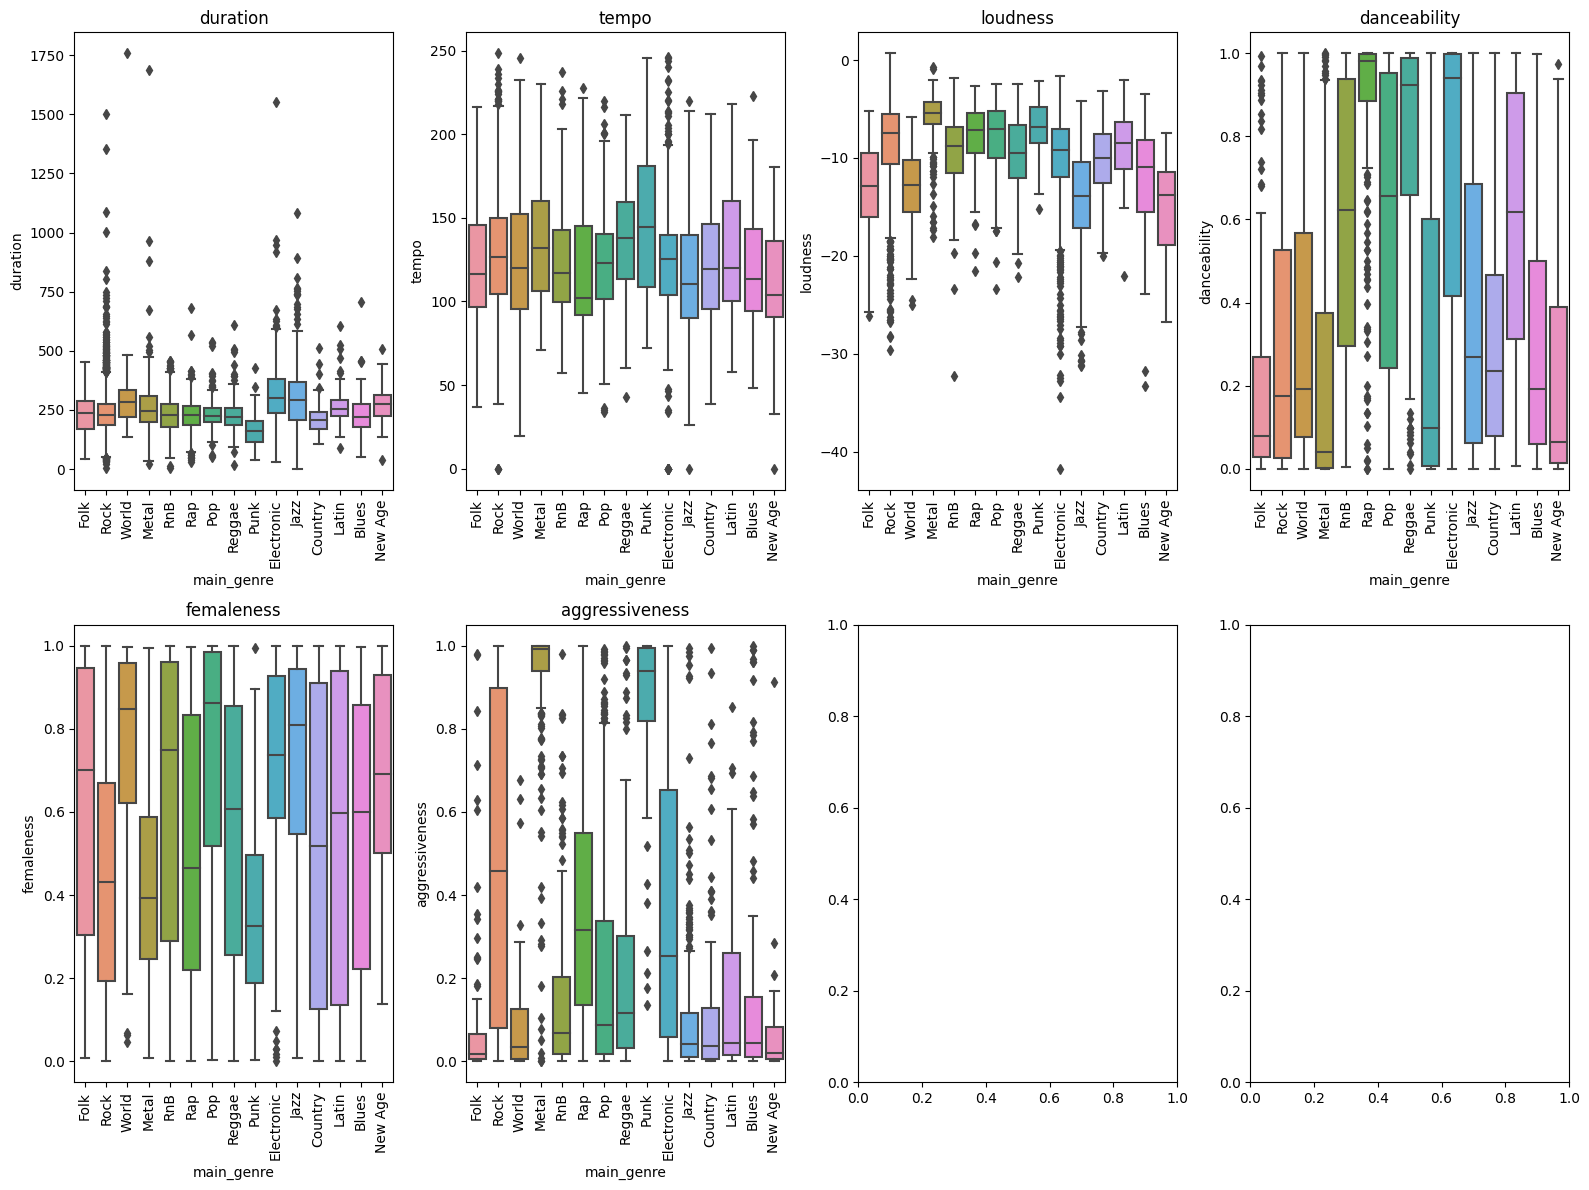

In [717]:
categorical_feature = 'main_genre' 
numerical_features = ['duration', 'tempo', 'loudness', 'danceability', 'femaleness', 'aggressiveness']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))

for i, feature in enumerate(numerical_features):
    row, col = i // 4, i % 4
    sns.boxplot(x=categorical_feature, y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].tick_params(axis='x', labelrotation=90)
    
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

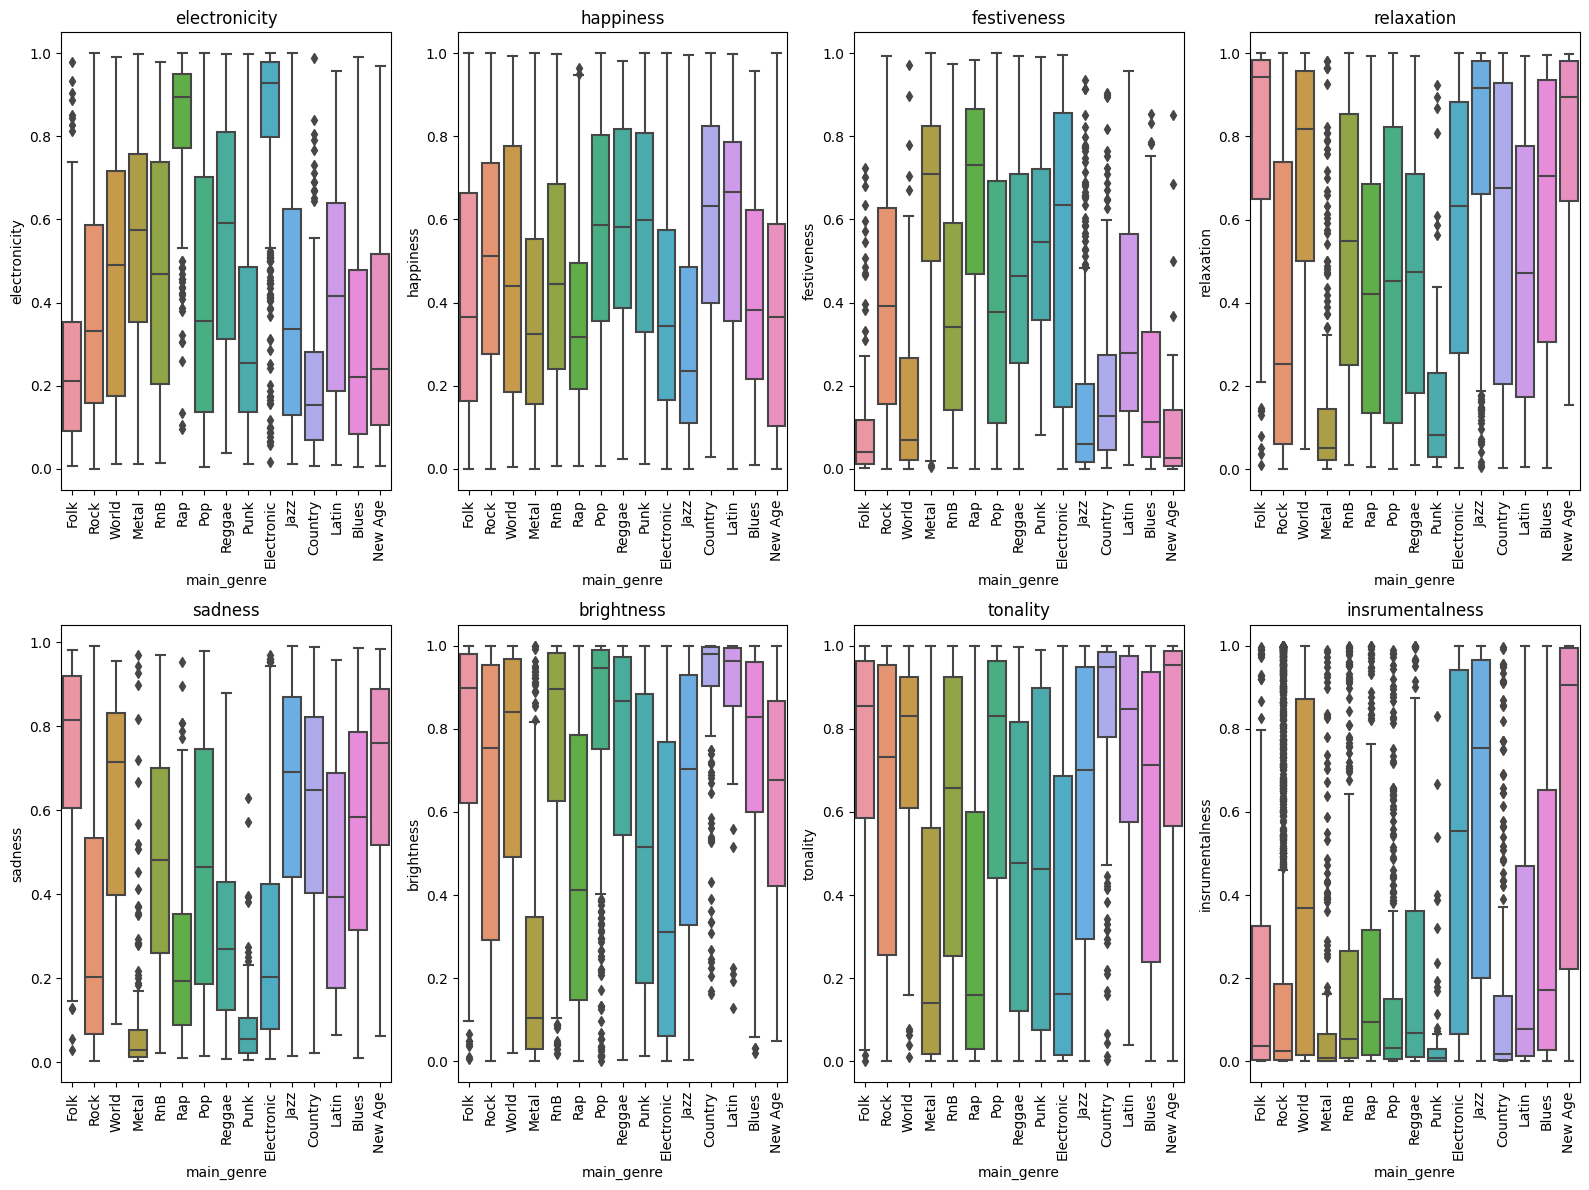

In [718]:


categorical_feature = 'main_genre' 
numerical_features = ['electronicity', 'happiness', 'festiveness', 'relaxation', 'sadness', 'brightness', 'tonality', 'insrumentalness']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))

for i, feature in enumerate(numerical_features):
    row, col = i // 4, i % 4
    sns.boxplot(x=categorical_feature, y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].tick_params(axis='x', labelrotation=90)
    
plt.tight_layout()
plt.show


In [679]:
numerical_features = ['duration', 'tempo', 'loudness', 'danceability', 'femaleness', 'aggressiveness', 'electronicity', 'happiness', 'festiveness', 'relaxation', 'sadness', 'brightness', 'tonality', 'insrumentalness']
categorical_feature = 'main_genre' 
X = df[numerical_features]
y = df[categorical_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True)

In [53]:
space = {
    'criterion': hp.choice('criterion', ['entropy']),
    'splitter': hp.choice('splitter', ['best','random']),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 3,20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 20, 1)
}



def objective(space):


    classifier = DecisionTreeClassifier(
        criterion=space['criterion'],
        splitter=space['splitter'],
        max_depth=int(6),
        min_samples_split=int(space['min_samples_split']),
        min_samples_leaf=int(space['min_samples_leaf']),
        random_state=12
    )

    score = cross_val_score(classifier, X_train, y_train, cv=5).mean()

    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

print(best)

100%|██████| 100/100 [00:18<00:00,  5.48trial/s, best loss: -0.4808988764044944]
{'criterion': 0, 'max_depth': 7.0, 'min_samples_leaf': 18.0, 'min_samples_split': 17.0, 'splitter': 1}


In [58]:
best_params = {
    'criterion': ['gini', 'entropy'][best['criterion']],
    'splitter': ['best', 'random'][best['splitter']],
    'max_depth': int(best['max_depth']),
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf'])
}


ptree = Pipeline([
    ('tree', DecisionTreeClassifier(**best_params))
])
ptree.fit(X_train, y_train)

Pipeline(steps=[('tree',
                 DecisionTreeClassifier(max_depth=7, min_samples_leaf=18,
                                        min_samples_split=17,
                                        splitter='random'))])

In [59]:
get_cv_scores_report_classification(ptree,X_test,y_test,5)

Accuracy en CV: mean 0.46, std 0.02
Recall en CV: mean 0.46, std 0.02


In [65]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 30, 1, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.5),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2'])  
}

def objective(params):
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds,average='weighted' )
    return {'loss': 1 - f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = space_eval(space, best)

print("Mejores parámetros:", best_params)

100%|███████| 100/100 [01:27<00:00,  1.14trial/s, best loss: 0.6034504810084357]
Mejores parámetros: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 0.011503356534689474, 'min_samples_split': 0.01784124220965641, 'n_estimators': 100}


In [66]:
rfr = RandomForestClassifier(**best_params)
rfr.fit(X_train, y_train)
get_cv_scores_report_classification(rfr,X_test,y_test,5)

Accuracy en CV: mean 0.50, std 0.02
Recall en CV: mean 0.50, std 0.02


In [77]:
y_pred = rfr.predict(X_test)
class_names =y_test.unique()

cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

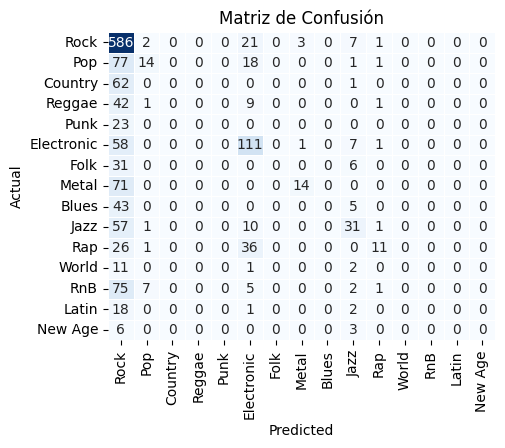

In [78]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [680]:
df = df.merge(features[['track_id','length']].set_index('track_id'), left_index = True, right_index  = True, how = 'inner')

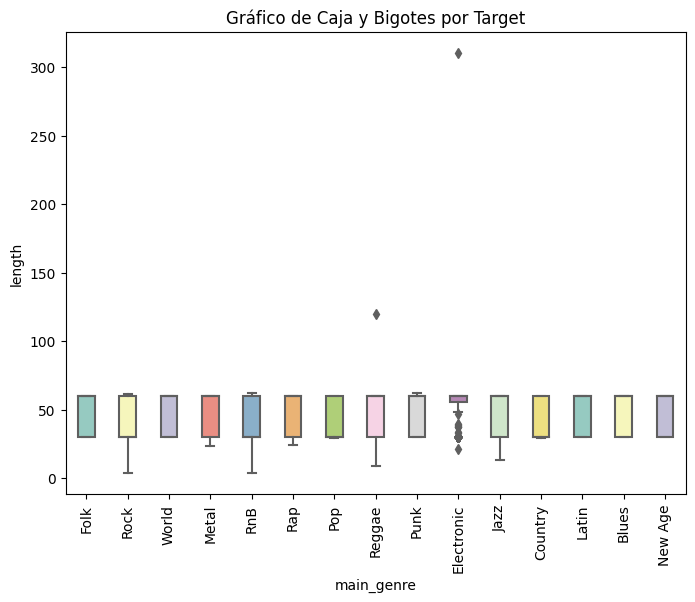

In [201]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='main_genre', y='length', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

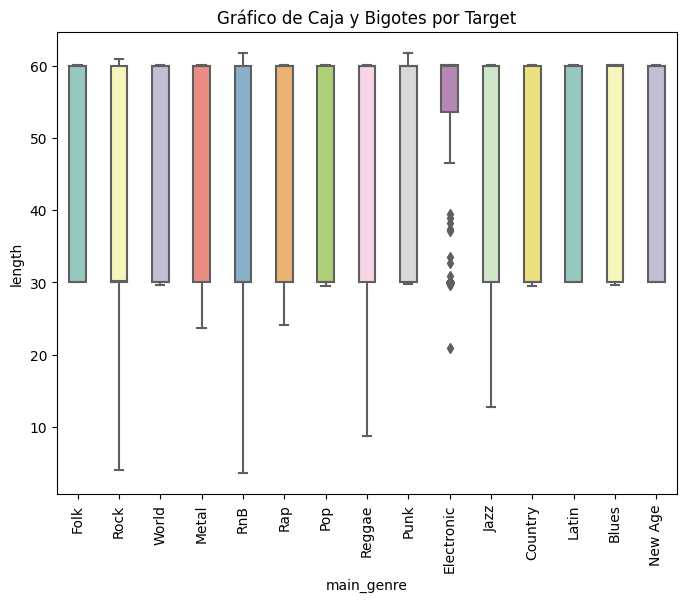

In [202]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df.loc[df['length'] < 100], x='main_genre', y='length', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

In [96]:
df['main_genre'].value_counts()

main_genre
Rock          2066
Electronic     594
Pop            369
Jazz           334
RnB            299
Metal          284
Rap            248
Country        211
Reggae         178
Blues          161
Folk           123
Punk            76
Latin           69
World           45
New Age         29
Name: count, dtype: int64

In [101]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 30, 1, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.5),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2'])  
}

def objective(params):
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds,average='weighted' )
    return {'loss': 1 - f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = space_eval(space, best)

print("Mejores parámetros:", best_params)

100%|███████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.6623763305763746]
Mejores parámetros: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 0.02905947640195438, 'min_samples_split': 0.07942071504504439, 'n_estimators': 50}


In [102]:
rfr2 = RandomForestClassifier(**best_params)
rfr2.fit(X_train, y_train)
get_cv_scores_report_classification(rfr2,X_test,y_test,5)

Accuracy en CV: mean 0.47, std 0.01
Recall en CV: mean 0.47, std 0.01


In [105]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 31, 1, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
}

def objective(params):
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)  # Usamos datos de validación en lugar de entrenamiento para la evaluación
    score = accuracy_score(y_test, preds)
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params = space_eval(space, best)

print("Mejores parámetros:", best_params)

100%|████████| 10/10 [03:12<00:00, 19.24s/trial, best loss: -0.5504587155963303]
Mejores parámetros: {'learning_rate': 0.044063245833782815, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 0.13151106282061228, 'min_samples_split': 0.025158950423283987, 'n_estimators': 250}


In [106]:
get_cv_scores_report_classification(rfr2,X_test,y_test,5)

Accuracy en CV: mean 0.47, std 0.01
Recall en CV: mean 0.47, std 0.01


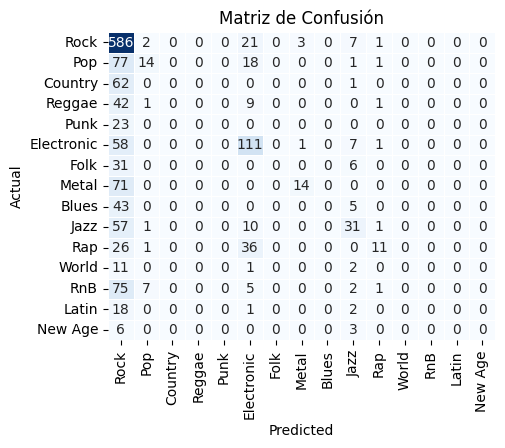

In [107]:
y_pred = rfr.predict(X_test)
class_names =y_test.unique()

cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

el problema es que esta clasificando la mayoria como rock, ya se igualo la muestra de cada categoria y sigue teniendo el mismo problema, se necesitan más caracteristicas que ayuden a diferenciar entre cada genero, dado que son demasiadas se va a hacer lo siguiente 
1. escogo una categoria de los 14 generos
2. hago una busqueda exaustiva entre todas las variables numericas y me traigo aquella con mayor diferencia en la media para cuando una cancion es de el genero y cuando no
3. hago una busqueda exaustiva entre todas las variables categoricas y me traigo aquella con mayor diferencia en la proporcion para cuando una cancion es de el genero y cuando no

In [681]:
lirics = pd.read_csv('song_lyrics.csv')

df_completo = genero.merge(summary,on = 'track_id', how ='left')
df_completo= df_completo.merge(features, on = 'track_id' , how  = 'left')
df_completo = df_completo.merge(lirics,  on = 'track_id' , how  = 'left')

In [682]:
df_completo  = df_completo.set_index('track_id')

In [683]:
lirics  = lirics.set_index('track_id')

las columnas de lirics las llenamos con 0 los caso de na

In [684]:

col  = lirics.columns
df_completo[col] = df_completo[col].fillna(0)
df_completo


,main_genre,song_id,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,...,when,where,who,will,with,would,y,yeah,you,your
track_id,,,,,,,,,,,,,,,,,,,,,
TRSZBVQ128F425D5B6,Rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRRJNCE128F9319E52,RnB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRIZJQX128F1472163,Folk,SOIHAPC12A6D4F6F57,0.431,2.032,0.347,0.0,1988.0,294.79138,0.349,Cabin Fever,...,0.0,1.0,0.0,6.0,3.0,0.0,0.0,0.0,1.0,0.0
TRBXBWB128F92F9F2B,Rap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRFBZFH12903CBDABB,Electronic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRHKNDN128F9320924,Blues,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRGIYIR128F92DCDF1,Rock,SOJFGKC12AB017C33C,0.625,0.160,0.491,0.0,2008.0,376.63302,0.799,Underneath The Stars,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0
TRVFMDX128F42915F2,Punk,SOJTJKO12A8C13EDD6,0.617,0.348,0.653,0.0,1986.0,170.78812,0.231,Bugs,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0


calculamos una columna correspodiente al total de palabras de la cancion  

In [685]:
df_completo['n_palabras'] = df_completo[col].sum(axis= 1)

/tmp/ipykernel_23345/1752867761.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_completo['n_palabras'] = df_completo[col].sum(axis= 1)


In [686]:
df_completo =  df_completo.drop('song_id', axis  = 1)

In [687]:
df_completo

,main_genre,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,title,start_of_fade_out,...,where,who,will,with,would,y,yeah,you,your,n_palabras
track_id,,,,,,,,,,,,,,,,,,,,,
TRSZBVQ128F425D5B6,Rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRRJNCE128F9319E52,RnB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRIZJQX128F1472163,Folk,0.431,2.032,0.347,0.0,1988.0,294.79138,0.349,Cabin Fever,279.899,...,1.0,0.0,6.0,3.0,0.0,0.0,0.0,1.0,0.0,189.0
TRBXBWB128F92F9F2B,Rap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRFBZFH12903CBDABB,Electronic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRHKNDN128F9320924,Blues,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRGIYIR128F92DCDF1,Rock,0.625,0.160,0.491,0.0,2008.0,376.63302,0.799,Underneath The Stars,361.593,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0,71.0
TRVFMDX128F42915F2,Punk,0.617,0.348,0.653,0.0,1986.0,170.78812,0.231,Bugs,167.369,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,69.0


In [688]:
df_completo.select_dtypes(include=['number'])

,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,start_of_fade_out,analysis_sample_rate_x,time_signature,...,where,who,will,with,would,y,yeah,you,your,n_palabras
track_id,,,,,,,,,,,,,,,,,,,,,
TRSZBVQ128F425D5B6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRRJNCE128F9319E52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRIZJQX128F1472163,0.431,2.032,0.347,0.0,1988.0,294.79138,0.349,279.899,22050.0,4.0,...,1.0,0.0,6.0,3.0,0.0,0.0,0.0,1.0,0.0,189.0
TRBXBWB128F92F9F2B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRFBZFH12903CBDABB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRHKNDN128F9320924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRGIYIR128F92DCDF1,0.625,0.160,0.491,0.0,2008.0,376.63302,0.799,361.593,22050.0,4.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0,71.0
TRVFMDX128F42915F2,0.617,0.348,0.653,0.0,1986.0,170.78812,0.231,167.369,22050.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,69.0


In [689]:
df_completo.select_dtypes(include=['O'])

,main_genre,title,artist_id,artist_name,release,codec,downmix,md5_encoded
track_id,,,,,,,,
TRSZBVQ128F425D5B6,Rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRRJNCE128F9319E52,RnB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRIZJQX128F1472163,Folk,Cabin Fever,ARE4SDM1187FB4D7E4,David Wilcox,Breakfast At The Circus,mp3,mix,aa58f6e29cb1b82c5d93b840fc642176
TRBXBWB128F92F9F2B,Rap,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRFBZFH12903CBDABB,Electronic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
TRHKNDN128F9320924,Blues,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRGIYIR128F92DCDF1,Rock,Underneath The Stars,ARWA6NT1187FB3F15C,The Cure,4:13 Dream,mp3,mix,3209e35b41ad2eb2c932e08b5a5e83d1
TRVFMDX128F42915F2,Punk,Bugs,ARTPCQ41187B9AB42C,Adrenalin O.D.,Humungousfungusamongus,NaN,NaN,NaN


de las variables title, artist_id, release, y md5_encoded las eliminamos, no son categoricas

In [690]:
df_completo = df_completo.drop(['title','artist_id', 'release','md5_encoded'], axis = 1)
df_completo.select_dtypes(include=['O'])

,main_genre,artist_name,codec,downmix
track_id,,,,
TRSZBVQ128F425D5B6,Rock,NaN,NaN,NaN
TRRJNCE128F9319E52,RnB,NaN,NaN,NaN
TRIZJQX128F1472163,Folk,David Wilcox,mp3,mix
TRBXBWB128F92F9F2B,Rap,NaN,NaN,NaN
TRFBZFH12903CBDABB,Electronic,NaN,NaN,NaN
...,...,...,...,...
TRHKNDN128F9320924,Blues,NaN,NaN,NaN
TRGIYIR128F92DCDF1,Rock,The Cure,mp3,mix
TRVFMDX128F42915F2,Punk,Adrenalin O.D.,NaN,NaN


vamos a reemplazar Nan con 'sin informacion'

In [691]:
col = ['artist_name','codec','downmix']
df_completo[col] = df_completo[col].fillna('sin informacion')

In [692]:
df_completo.select_dtypes(include=['O'])

,main_genre,artist_name,codec,downmix
track_id,,,,
TRSZBVQ128F425D5B6,Rock,sin informacion,sin informacion,sin informacion
TRRJNCE128F9319E52,RnB,sin informacion,sin informacion,sin informacion
TRIZJQX128F1472163,Folk,David Wilcox,mp3,mix
TRBXBWB128F92F9F2B,Rap,sin informacion,sin informacion,sin informacion
TRFBZFH12903CBDABB,Electronic,sin informacion,sin informacion,sin informacion
...,...,...,...,...
TRHKNDN128F9320924,Blues,sin informacion,sin informacion,sin informacion
TRGIYIR128F92DCDF1,Rock,The Cure,mp3,mix
TRVFMDX128F42915F2,Punk,Adrenalin O.D.,sin informacion,sin informacion


para artis_name vamos a hacer una limpieza básica de texto 

In [693]:
df_completo['artist_name'] = df_completo['artist_name'].apply(clean_text)

In [694]:
df_completo['artist_name'].value_counts().reset_index().sort_values(by  = 'count')

,artist_name,count
2156,son doobie,1
2866,elvis presley the jordanaires,1
2867,o v wright,1
2868,nightfall,1
2869,zap pow,1
...,...,...
7,radiohead,6
3,weezer,7
2,bruce springsteen,7
1,amorphis,7


In [695]:
df_completo[['main_genre','codec']].value_counts()

main_genre  codec          
Rock        mp3                2069
            sin informacion    1344
Electronic  mp3                 594
            sin informacion     404
Pop         mp3                 369
Jazz        mp3                 334
RnB         mp3                 299
Metal       mp3                 288
Rap         mp3                 248
Jazz        sin informacion     232
Pop         sin informacion     227
Country     mp3                 211
Rap         sin informacion     183
Reggae      mp3                 179
Blues       mp3                 161
Metal       sin informacion     161
Country     sin informacion     154
RnB         sin informacion     145
Reggae      sin informacion     144
Folk        mp3                 123
Blues       sin informacion     102
Folk        sin informacion      79
Punk        mp3                  76
Latin       mp3                  69
Punk        sin informacion      51
Latin       sin informacion      51
World       mp3                  45


In [696]:
df_completo['downmix'].value_counts()

downmix
mix                5094
sin informacion    3322
Name: count, dtype: int64

las categoricas son variables unitarias por las que no las tomamos en cuenta

In [195]:


generos_unicos = df_completo['main_genre'].unique()

numero_columnas_a_extraer = 1

resultados = []


for genero_referencia in generos_unicos:

    df_referencia = df_completo[df_completo['main_genre'] == genero_referencia]

    media_referencia = df_referencia.select_dtypes(include=['number']).mean()

    diferencia_media = (
        df_completo[df_completo['main_genre'] != genero_referencia].select_dtypes(include=['number']).mean() - media_referencia
    )

    columnas_numericas_seleccionadas = diferencia_media.abs().nlargest(numero_columnas_a_extraer).index

    resultados_num= {
        'Género de Referencia': genero_referencia,
        'Variables Numéricas Seleccionadas': columnas_numericas_seleccionadas.tolist()
    }
    resultados.append(resultados_num)

print(resultados)


[{'Género de Referencia': 'Rock', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'RnB', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'Folk', 'Variables Numéricas Seleccionadas': ['sample_rate']}, {'Género de Referencia': 'Rap', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'Electronic', 'Variables Numéricas Seleccionadas': ['sample_rate']}, {'Género de Referencia': 'Jazz', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'World', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'Metal', 'Variables Numéricas Seleccionadas': ['sample_rate']}, {'Género de Referencia': 'Blues', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'Country', 'Variables Numéricas Seleccionadas': ['bit_rate']}, {'Género de Referencia': 'Pop', 'Variables Numéricas Seleccionadas': ['sample_rate']}, {'Género de Referencia': 'Reggae', 'Variabl

In [196]:
pd.DataFrame(resultados)

,Género de Referencia,Variables Numéricas Seleccionadas
0,Rock,[bit_rate]
1,RnB,[bit_rate]
2,Folk,[sample_rate]
3,Rap,[bit_rate]
4,Electronic,[sample_rate]
5,Jazz,[bit_rate]
6,World,[bit_rate]
7,Metal,[sample_rate]
8,Blues,[bit_rate]
9,Country,[bit_rate]


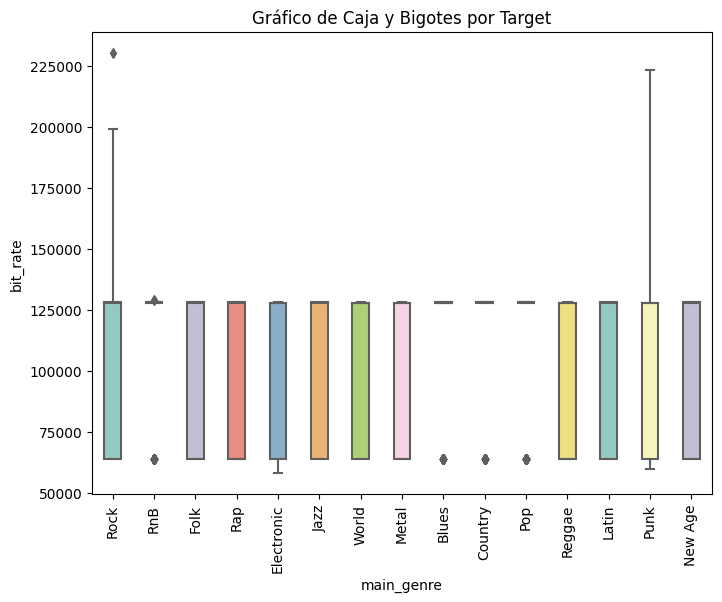

In [203]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_completo, x='main_genre', y='bit_rate', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

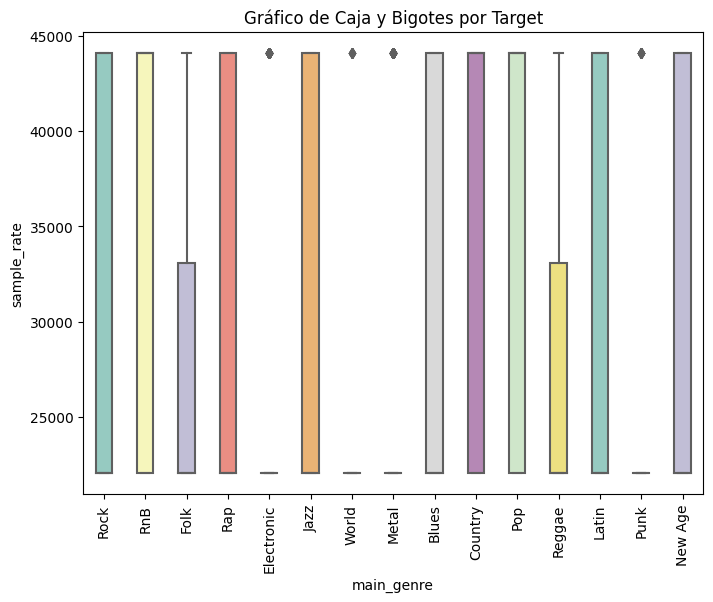

In [204]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_completo, x='main_genre', y='sample_rate', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

In [759]:
df = genero.merge(summary[['track_id','duration','tempo','loudness']],on = 'track_id', how ='inner')
df = df.merge(features[['track_id',"danceability","femaleness","aggressiveness","electronicity","happiness","festiveness","relaxation","sadness",
    "brightness","tonality","insrumentalness",'sample_rate','bit_rate']], on = 'track_id' , how  = 'inner')

In [382]:
df['main_genre'].value_counts()

main_genre
Rock          2066
Electronic     594
Pop            369
Jazz           334
RnB            299
Metal          284
Rap            248
Country        211
Reggae         178
Blues          161
Folk           123
Punk            76
Latin           69
World           45
New Age         29
Name: count, dtype: int64

In [245]:

numerical_features = df.select_dtypes(include=['number']).columns
categorical_feature = 'main_genre' 
X = df[numerical_features]
y = df[categorical_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True)

In [246]:

X_train = X_train.merge(y_train, right_index = True, left_index = True)
clase_mas_grande = X_train['main_genre'].value_counts().idxmax()
tamaño_mas_grande = X_train['main_genre'].value_counts().max()
equilibrado_data = pd.DataFrame()

for clase, grupo in X_train.groupby('main_genre'):
    if len(grupo) < tamaño_mas_grande:
        bootstrap_samples = grupo.sample(tamaño_mas_grande, replace=True)
        equilibrado_data = pd.concat([equilibrado_data, bootstrap_samples])
    else:
        equilibrado_data = pd.concat([equilibrado_data, grupo])



In [247]:
X_train  = equilibrado_data[equilibrado_data.select_dtypes(include=['number']).columns]
y_train  = equilibrado_data[equilibrado_data.select_dtypes(include=['O']).columns]

In [248]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 31, 1, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
}

def objective(params):
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)  # Usamos datos de validación en lugar de entrenamiento para la evaluación
    score = accuracy_score(y_test, preds)
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params = space_eval(space, best)

print("Mejores parámetros:", best_params)

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▉        | 1/10 [01:19<11:59, 79.97s/trial, best loss: -0.3289646133682831]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▊       | 2/10 [01:50<06:45, 50.75s/trial, best loss: -0.3289646133682831]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██▋      | 3/10 [02:03<03:54, 33.47s/trial, best loss: -0.3289646133682831]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▌     | 4/10 [03:01<04:20, 43.46s/trial, best loss: -0.3289646133682831]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████▌    | 5/10 [03:51<03:48, 45.65s/trial, best loss: -0.3289646133682831]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|█████▍   | 6/10 [05:56<04:50, 72.52s/trial, best loss: -0.3289646133682831]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|█████▌  | 7/10 [07:55<04:23, 87.98s/trial, best loss: -0.33682830930537355]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|██████▍ | 8/10 [08:33<02:23, 71.95s/trial, best loss: -0.33682830930537355]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|███████▏| 9/10 [09:10<01:01, 61.01s/trial, best loss: -0.33682830930537355]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|███████| 10/10 [10:40<00:00, 64.05s/trial, best loss: -0.33682830930537355]
Mejores parámetros: {'learning_rate': 0.1521052044855511, 'max_depth': 23, 'max_features': 'log2', 'min_samples_leaf': 0.12306987540190156, 'min_samples_split': 0.8920786282633199, 'n_estimators': 450}


In [249]:
gbm = GradientBoostingClassifier(**best_params)
gbm.fit(X_train, y_train)

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.1521052044855511, max_depth=23,
                           max_features='log2',
                           min_samples_leaf=0.12306987540190156,
                           min_samples_split=0.8920786282633199,
                           n_estimators=450)

In [251]:
get_cv_scores_report_classification(gbm,X_test,y_test,5)

Accuracy en CV: mean 0.48, std 0.03
Recall en CV: mean 0.48, std 0.03


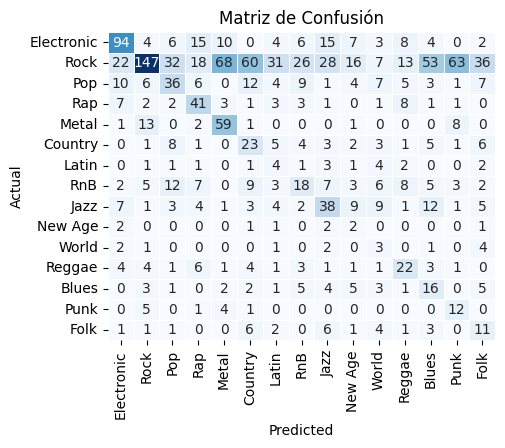

In [254]:
y_pred = gbm.predict(X_test)
class_names =y_test.unique()

cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

ahora el problema es que muchos son de rock y se clasifican diferente, para solucionar esto solo vamos a submuestrear las variable pero solo hasta que tengan 1000 registros, no los 2066 que tiene rock, los que tienen registros similares a rock se mantienen igual

In [257]:
df['main_genre'].value_counts()

main_genre
Rock          2066
Electronic     594
Pop            369
Jazz           334
RnB            299
Metal          284
Rap            248
Country        211
Reggae         178
Blues          161
Folk           123
Punk            76
Latin           69
World           45
New Age         29
Name: count, dtype: int64

In [261]:
numerical_features = df.select_dtypes(include=['number']).columns
categorical_feature = 'main_genre' 
X = df[numerical_features]
y = df[categorical_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True)

In [262]:
X_train = X_train.merge(y_train, right_index = True, left_index = True)
equilibrado_data = pd.DataFrame()

for clase, grupo in X_train.groupby('main_genre'):
    if clase != 'Rock':
        bootstrap_samples = grupo.sample(1000, replace=True)
        equilibrado_data = pd.concat([equilibrado_data, bootstrap_samples])
    else:
        equilibrado_data = pd.concat([equilibrado_data, grupo])
    

In [263]:
equilibrado_data['main_genre'].value_counts()

main_genre
Rock          1446
Blues         1000
Country       1000
Electronic    1000
Folk          1000
Jazz          1000
Latin         1000
Metal         1000
New Age       1000
Pop           1000
Punk          1000
Rap           1000
Reggae        1000
RnB           1000
World         1000
Name: count, dtype: int64

In [264]:
X_train  = equilibrado_data[equilibrado_data.select_dtypes(include=['number']).columns]
y_train  = equilibrado_data[equilibrado_data.select_dtypes(include=['O']).columns]

In [265]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 31, 1, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
}

def objective(params):
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)  # Usamos datos de validación en lugar de entrenamiento para la evaluación
    score = accuracy_score(y_test, preds)
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params = space_eval(space, best)

print("Mejores parámetros:", best_params)

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▊       | 1/10 [00:11<01:46, 11.79s/trial, best loss: -0.32503276539973786]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▌      | 2/10 [02:54<13:23, 100.43s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██▋      | 3/10 [03:26<08:05, 69.34s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▌     | 4/10 [04:38<07:01, 70.18s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████▌    | 5/10 [05:12<04:46, 57.27s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|█████▍   | 6/10 [05:22<02:44, 41.12s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|██████▎  | 7/10 [05:42<01:43, 34.34s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|███████▏ | 8/10 [06:52<01:31, 45.52s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|████████ | 9/10 [08:12<00:56, 56.29s/trial, best loss: -0.5019659239842726]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|████████| 10/10 [09:13<00:00, 55.37s/trial, best loss: -0.5019659239842726]
Mejores parámetros: {'learning_rate': 0.1518727173847423, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.04834440758168503, 'min_samples_split': 0.22783810249823597, 'n_estimators': 350}


In [267]:
gbm2 = GradientBoostingClassifier(**best_params)
gbm2.fit(X_train, y_train)

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.1518727173847423, max_depth=8,
                           max_features='sqrt',
                           min_samples_leaf=0.04834440758168503,
                           min_samples_split=0.22783810249823597,
                           n_estimators=350)

In [310]:
get_cv_scores_report_classification(gbm2,X_test,y_test,5)

Accuracy: 0.5123 (+/- 0.0396)


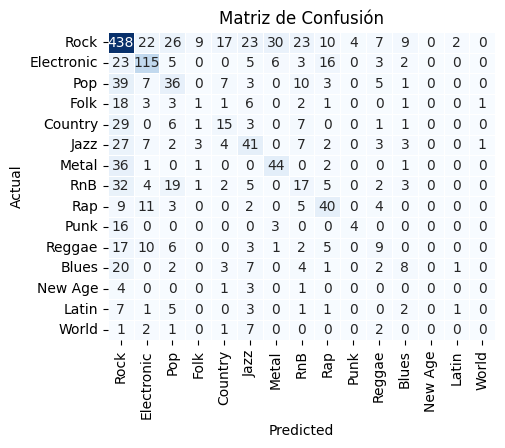

In [269]:
y_pred = gbm2.predict(X_test)
class_names =y_test.unique()

cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

busquemos más caracteristica

In [272]:

generos_unicos = df_completo['main_genre'].unique()

numero_columnas_a_extraer = 4

resultados = []


for genero_referencia in generos_unicos:

    df_referencia = df_completo[df_completo['main_genre'] == genero_referencia]

    media_referencia = df_referencia.select_dtypes(include=['number']).mean()

    diferencia_media = (
        df_completo[df_completo['main_genre'] != genero_referencia].select_dtypes(include=['number']).mean() - media_referencia
    )

    columnas_numericas_seleccionadas = diferencia_media.abs().nlargest(numero_columnas_a_extraer).index

    resultados_num= {
        'Género de Referencia': genero_referencia,
        'Variables Numéricas Seleccionadas': columnas_numericas_seleccionadas.tolist()
    }
    resultados.append(resultados_num)

pd.DataFrame(resultados)


,Género de Referencia,Variables Numéricas Seleccionadas
0,Rock,"[bit_rate, sample_rate, duration, start_of_fad..."
1,RnB,"[bit_rate, sample_rate, start_of_fade_out, dur..."
2,Folk,"[sample_rate, bit_rate, duration, start_of_fad..."
3,Rap,"[bit_rate, sample_rate, n_palabras, duration]"
4,Electronic,"[sample_rate, bit_rate, duration, start_of_fad..."
5,Jazz,"[bit_rate, sample_rate, duration, start_of_fad..."
6,World,"[bit_rate, sample_rate, duration, start_of_fad..."
7,Metal,"[sample_rate, bit_rate, duration, start_of_fad..."
8,Blues,"[bit_rate, sample_rate, n_palabras, duration]"
9,Country,"[bit_rate, sample_rate, start_of_fade_out, dur..."


In [279]:
tmp = pd.DataFrame(resultados)
tmp.explode('Variables Numéricas Seleccionadas')['Variables Numéricas Seleccionadas'].unique()

array(['bit_rate', 'sample_rate', 'duration', 'start_of_fade_out',
       'n_palabras'], dtype=object)

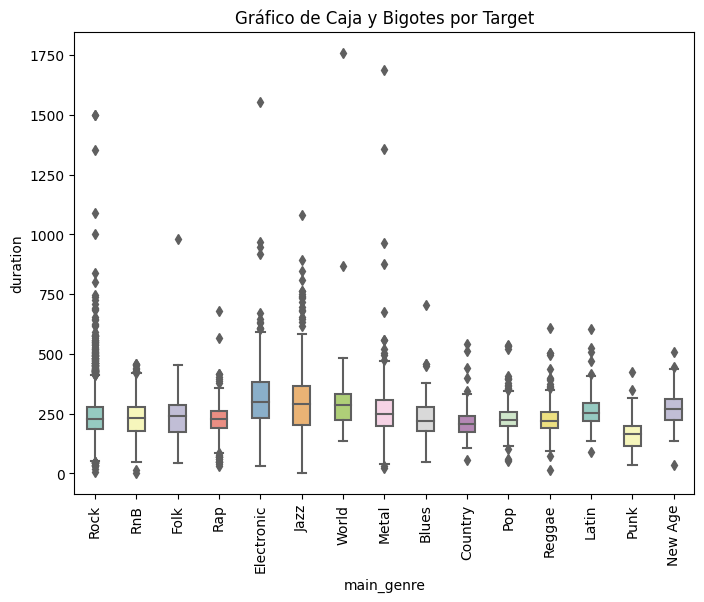

In [280]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_completo, x='main_genre', y='duration', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

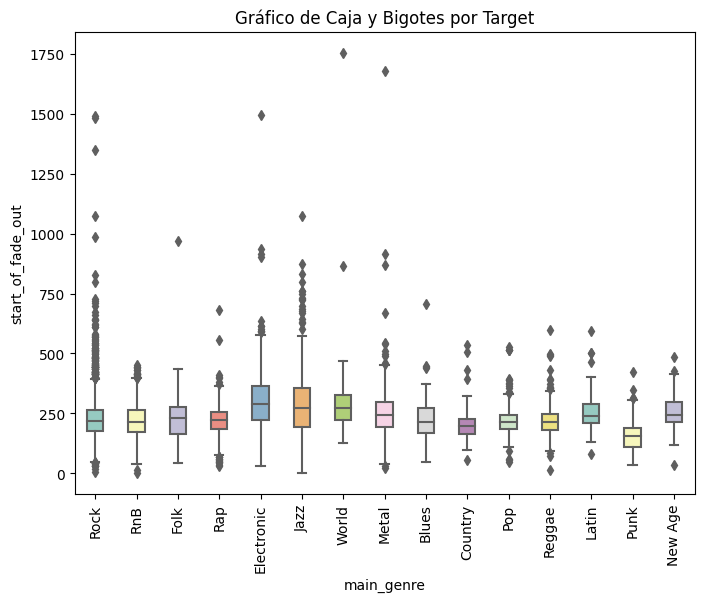

In [281]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_completo, x='main_genre', y='start_of_fade_out', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

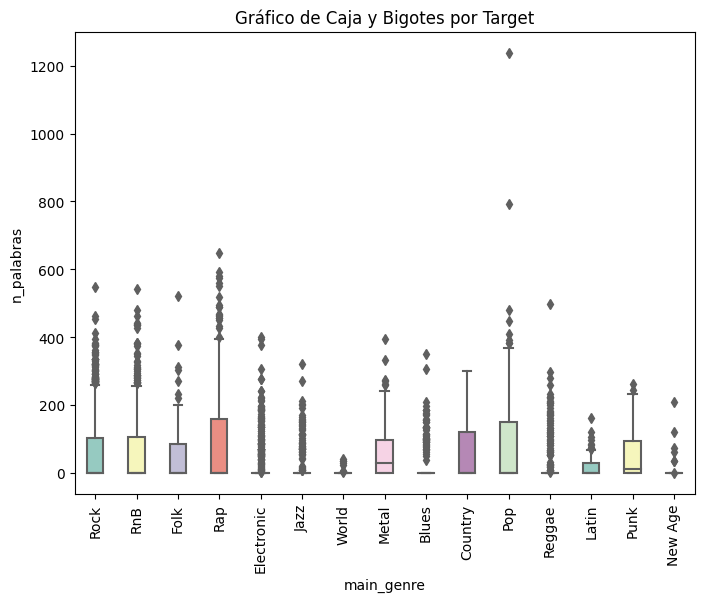

In [282]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_completo, x='main_genre', y='n_palabras', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes por Target')
plt.xticks(rotation=90)
plt.show()

In [760]:
df = df.set_index('track_id')

In [761]:

cols =  df.columns.to_list() +['start_of_fade_out','n_palabras']

In [762]:
df = df_completo[cols]
df = df[df.isnull().sum(axis = 1) ==  0]

In [701]:
df['main_genre'].value_counts()

main_genre
Rock          2066
Electronic     594
Pop            369
Jazz           334
RnB            299
Metal          284
Rap            248
Country        211
Reggae         178
Blues          161
Folk           123
Punk            76
Latin           69
World           45
New Age         29
Name: count, dtype: int64

In [388]:
numerical_features = df.select_dtypes(include=['number']).columns
categorical_feature = 'main_genre' 
X = df[numerical_features]
y = df[categorical_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True)

In [389]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 31, 1, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
}

def objective(params):
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)  # Usamos datos de validación en lugar de entrenamiento para la evaluación
    score = accuracy_score(y_test, preds)
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params = space_eval(space, best)

print("Mejores parámetros:", best_params)

100%|████████| 10/10 [02:54<00:00, 17.41s/trial, best loss: -0.5511140235910879]
Mejores parámetros: {'learning_rate': 0.11688435997040017, 'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 0.05578703445922147, 'min_samples_split': 0.6878784645866493, 'n_estimators': 200}


In [390]:
gbm3 = GradientBoostingClassifier(**best_params)
gbm3.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.11688435997040017, max_depth=29,
                           max_features='log2',
                           min_samples_leaf=0.05578703445922147,
                           min_samples_split=0.6878784645866493,
                           n_estimators=200)

In [391]:
get_cv_scores_report_classification(gbm3,X_test,y_test,5)

Accuracy: 0.5187 (+/- 0.0429)


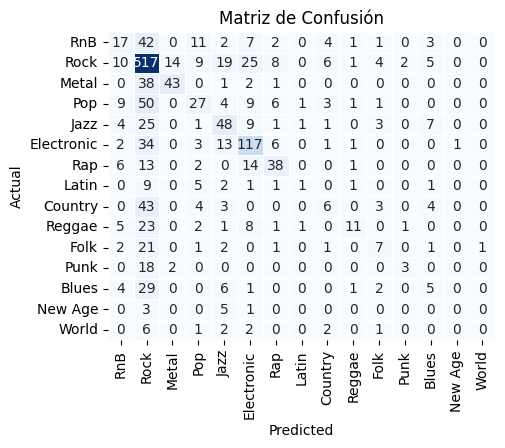

In [392]:
y_pred = gbm3.predict(X_test)
class_names =y_test.unique()

cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns
categorical_feature = 'main_genre' 
X = df[numerical_features]
y = df[categorical_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True)

medias = X_train.mean()
desviaciones = X_train.std()        
tr_col = X_train.columns

X_train = X_train.merge(y_train, right_index = True, left_index = True)
equilibrado_data = pd.DataFrame()
#tamaño = 700 
models = []
X_train_res = X_train

for tamaño in range(100, 1500, 100):
    print(tamaño)
    X_train = X_train_res
    for clase, grupo in X_train.groupby('main_genre'):
        if clase != 'Rock' or  len(grupo) < tamaño:
            bootstrap_samples = grupo.sample(tamaño, replace=True)
            muestras_ruido = {
               variable: np.random.normal(medias[variable], desviaciones[variable], len(bootstrap_samples))
                for variable in tr_col
                }
            bootstrap_samples[tr_col] = bootstrap_samples[tr_col] + pd.DataFrame(muestras_ruido, index = bootstrap_samples.index)
            
            equilibrado_data = pd.concat([equilibrado_data, bootstrap_samples])
            
        else:
            equilibrado_data = pd.concat([equilibrado_data, grupo])
    
    X_train  = equilibrado_data[equilibrado_data.select_dtypes(include=['number']).columns]
    y_train  = equilibrado_data[equilibrado_data.select_dtypes(include=['O']).columns]
    #X_train = scaler.fit_transform(X_train)
    space = {
        'n_estimators': hp.choice('n_estimators', np.arange(50, 501, 50, dtype=int)),
        'max_depth': hp.choice('max_depth', np.arange(5, 31, 1, dtype=int)),
        'min_samples_split': hp.uniform('min_samples_split', 0.01, 1.0),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
        'max_features': hp.choice('max_features', ['sqrt', 'log2']),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
    }
    
    def objective(params):
        np.random.seed(42)
    
        random.seed(42)
        model = GradientBoostingClassifier(**params)
        model.fit(X_train, y_train)
       
        preds = model.predict(X_test) 
        score = accuracy_score(y_test, preds)
        
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
    best_params = space_eval(space, best)
    np.random.seed(42)
    
    random.seed(42)
    gbmint = GradientBoostingClassifier(**best_params)
    gbmint.fit(X_train, y_train)
    models.append(gbmint)
    print("Mejores parámetros:", best_params)


100
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▊       | 1/10 [00:06<00:55,  6.12s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▌      | 2/10 [00:23<01:39, 12.49s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██▍     | 3/10 [00:28<01:06,  9.49s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▏    | 4/10 [01:02<01:54, 19.08s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████    | 5/10 [01:33<01:57, 23.42s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▊   | 6/10 [01:47<01:20, 20.18s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|█████▌  | 7/10 [02:23<01:15, 25.27s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|██████▍ | 8/10 [02:44<00:47, 23.77s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|███████▏| 9/10 [02:46<00:17, 17.01s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|███████| 10/10 [02:48<00:00, 16.83s/trial, best loss: -0.40629095674967236]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.05598353218316306, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 0.37452265956961067, 'min_samples_split': 0.7187893311351224, 'n_estimators': 100}
200
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▊       | 1/10 [00:35<05:23, 35.96s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▌      | 2/10 [01:15<05:02, 37.78s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██▍     | 3/10 [01:29<03:09, 27.02s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▏    | 4/10 [01:56<02:43, 27.20s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████    | 5/10 [02:38<02:42, 32.55s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▊   | 6/10 [03:24<02:28, 37.14s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|█████▌  | 7/10 [04:00<01:49, 36.57s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|██████▍ | 8/10 [04:30<01:08, 34.50s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|███████▏| 9/10 [05:15<00:38, 38.00s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|███████| 10/10 [06:12<00:00, 37.29s/trial, best loss: -0.40629095674967236]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.047735828815811385, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 0.26502579744320925, 'min_samples_split': 0.24343264318321323, 'n_estimators': 300}
300
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▋      | 1/10 [02:18<20:50, 138.99s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▌      | 2/10 [03:19<12:24, 93.00s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██▍     | 3/10 [03:56<07:50, 67.22s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▏    | 4/10 [04:44<05:57, 59.52s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████    | 5/10 [05:21<04:18, 51.69s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▊   | 6/10 [08:33<06:36, 99.23s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|█████▌  | 7/10 [10:08<04:53, 97.87s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|██████▍ | 8/10 [10:16<02:18, 69.35s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|███████▏| 9/10 [11:36<01:12, 72.49s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|███████| 10/10 [12:25<00:00, 74.55s/trial, best loss: -0.40629095674967236]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.07918509378394786, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 0.011949237803486603, 'min_samples_split': 0.4964261533900806, 'n_estimators': 300}
400
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▊       | 1/10 [00:37<05:33, 37.10s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▌      | 2/10 [02:44<12:02, 90.29s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██▍     | 3/10 [03:50<09:13, 79.00s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▌     | 4/10 [04:52<07:14, 72.45s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████▌    | 5/10 [05:09<04:21, 52.38s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|█████▍   | 6/10 [05:34<02:52, 43.17s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|██████▎  | 7/10 [06:58<02:49, 56.34s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|███████▏ | 8/10 [08:09<02:01, 60.98s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|████████ | 9/10 [09:39<01:10, 70.08s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|████████| 10/10 [11:26<00:00, 68.70s/trial, best loss: -0.4069462647444299]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.18539221265086817, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 0.3439627932167533, 'min_samples_split': 0.010812649546546154, 'n_estimators': 250}
500
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▋      | 1/10 [01:46<16:00, 106.71s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▌      | 2/10 [02:56<11:17, 84.72s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██     | 3/10 [05:46<14:26, 123.86s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|███▏    | 4/10 [08:19<13:32, 135.47s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|████    | 5/10 [10:48<11:42, 140.42s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▊   | 6/10 [13:07<09:18, 139.65s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|█████▌  | 7/10 [13:40<05:14, 104.82s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|██████▍ | 8/10 [16:37<04:15, 127.77s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|███████▏| 9/10 [18:05<01:55, 115.53s/trial, best loss: -0.4069462647444299]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|███████| 10/10 [21:55<00:00, 131.51s/trial, best loss: -0.4069462647444299]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.020957633654138434, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.46015379562301895, 'min_samples_split': 0.9623698193548477, 'n_estimators': 450}
600
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▋      | 1/10 [04:14<38:11, 254.57s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▍     | 2/10 [06:38<25:17, 189.68s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██     | 3/10 [08:55<19:19, 165.60s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|██▊    | 4/10 [12:49<19:14, 192.40s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|███▌   | 5/10 [19:09<21:41, 260.28s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▊   | 6/10 [20:46<13:39, 204.80s/trial, best loss: -0.4076015727391874]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|█████▌  | 7/10 [21:19<07:25, 148.50s/trial, best loss: -0.4076015727391874]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|██████▍ | 8/10 [22:55<04:23, 131.90s/trial, best loss: -0.4076015727391874]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|███████▏| 9/10 [28:25<03:13, 193.81s/trial, best loss: -0.4076015727391874]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|███████| 10/10 [30:01<00:00, 180.16s/trial, best loss: -0.4076015727391874]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.19111261657222123, 'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 0.38548944640568916, 'min_samples_split': 0.21388779049026382, 'n_estimators': 200}
700
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▋      | 1/10 [06:10<55:35, 370.66s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▍     | 2/10 [09:50<37:35, 281.97s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██     | 3/10 [11:22<22:47, 195.37s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|██▊    | 4/10 [11:56<13:07, 131.33s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|███▌   | 5/10 [29:57<39:29, 473.93s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▏  | 6/10 [31:35<23:03, 345.99s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 70%|████▉  | 7/10 [34:45<14:45, 295.10s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|█████▌ | 8/10 [39:31<09:44, 292.30s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 90%|██████▎| 9/10 [42:49<04:22, 262.90s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|██████| 10/10 [46:20<00:00, 278.10s/trial, best loss: -0.40629095674967236]


/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.02664116359802095, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 0.0154699441642262, 'min_samples_split': 0.13947383256605364, 'n_estimators': 150}
800
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 10%|▌    | 1/10 [10:31<1:34:45, 631.75s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|█▍     | 2/10 [11:51<40:58, 307.33s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 30%|██     | 3/10 [14:29<27:51, 238.80s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|██▊    | 4/10 [15:22<16:32, 165.46s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|███▌   | 5/10 [19:10<15:39, 187.99s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|████▏  | 6/10 [27:47<20:00, 300.03s/trial, best loss: -0.40629095674967236]

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [395]:
np.random.seed(42)

random.seed(42)
gbm4 = GradientBoostingClassifier(**best_params)
gbm4.fit(X_train, y_train)

/home/luis/Documentos/formacion/Diplomado Ciencia de datos/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.0202361913896093, max_depth=22,
                           max_features='log2',
                           min_samples_leaf=0.15937017904601022,
                           min_samples_split=0.5365709149060761,
                           n_estimators=400)

In [397]:
get_cv_scores_report_classification(gbm4,X_test,y_test,5)

Accuracy: 0.5151 (+/- 0.0364)


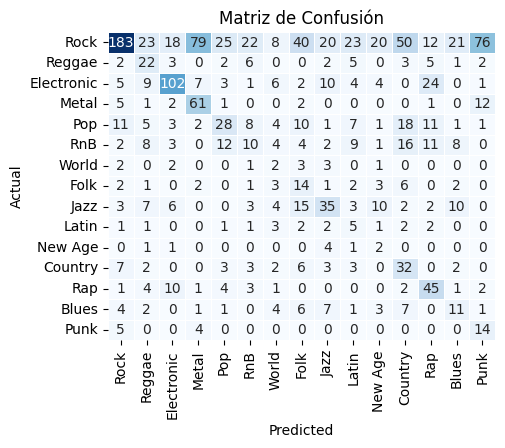

In [398]:
y_pred = gbm4.predict(X_test)
class_names =y_test.unique()

cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Regresion

In [517]:
location = pd.read_csv('artist_location.csv')
tags = pd.read_csv('artist_tags.csv')
terms = pd.read_csv('artist_terms.csv')
count = pd.read_csv('song_play_count.csv')

In [720]:
df2 = count.groupby('song_id')['play_count'].sum().reset_index()
df2 = df2.merge(summary[['song_id','year']], on = 'song_id')
df2

,song_id,play_count,year
0,SOAABDH12A6D4F7658,9,1999
1,SOAAGDJ12A8C13A1C6,661,2002
2,SOAAGQU12AB01843A8,1,2008
3,SOAALEG12A58A79808,282,2008
4,SOAAMTH12AF729D4E5,1021,2006
...,...,...,...
10367,SOZZTQU12AB017FAEE,159,2009
10368,SOZZWHT12A8C142264,125,2009
10369,SOZZXQJ12AB0184460,4,1983
10370,SOZZYDH12AAF3B31AF,7,1989


In [721]:
df2['year'].max()

2010

In [722]:
df2['antiguedad'] = 2011 - df2['year'] 
df2['target'] = df2['play_count']/df2['antiguedad']
df2 = df2.drop(['play_count','year','antiguedad'], axis = 1)
df2 = df2[df2.isnull().sum(axis = 1 ) == 0]
df2

,song_id,target
0,SOAABDH12A6D4F7658,0.750000
1,SOAAGDJ12A8C13A1C6,73.444444
2,SOAAGQU12AB01843A8,0.333333
3,SOAALEG12A58A79808,94.000000
4,SOAAMTH12AF729D4E5,204.200000
...,...,...
10367,SOZZTQU12AB017FAEE,79.500000
10368,SOZZWHT12A8C142264,62.500000
10369,SOZZXQJ12AB0184460,0.142857
10370,SOZZYDH12AAF3B31AF,0.318182


In [723]:
df2['target'].describe()

count    10372.000000
mean        87.504319
std        823.748258
min          0.019608
25%          1.166667
50%          5.152681
75%         24.500000
max      49119.000000
Name: target, dtype: float64

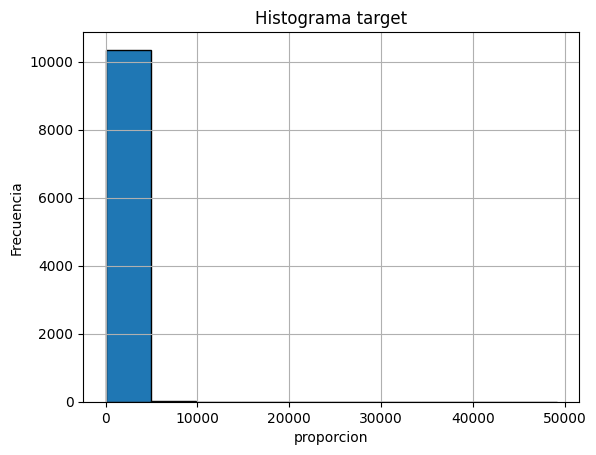

In [724]:
plt.hist(df2['target'], edgecolor='k')  
plt.title('Histograma target')
plt.xlabel('proporcion')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()

In [725]:
df2 = df2.merge(summary[['track_id','song_id']], on = 'song_id')
df2 = df2.merge(df_completo, on = 'track_id')

In [726]:
df2 = df2.set_index(['song_id','track_id'])


In [727]:
df2 = df2[df2.isnull().sum(axis = 1)  == 0]
df2

,,target,main_genre,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,start_of_fade_out,...,where,who,will,with,would,y,yeah,you,your,n_palabras
song_id,track_id,,,,,,,,,,,,,,,,,,,,,
SOAAMTH12AF729D4E5,TRMCYOC128F147B791,204.200000,Rap,0.456,2.490,0.806,0.0,2006.0,208.87465,1.000,208.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAYXD12A58A79881,TRCADAE128F424C047,8.833333,Metal,0.292,0.156,0.037,0.0,2005.0,197.48526,0.412,192.122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOABOXN12A8C13895F,TRPPFIG128F425F57B,4.266667,New Age,0.257,0.411,0.771,0.0,1996.0,312.92036,1.000,294.377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOABWFH12A8C13753E,TRZNNKN128F4263F41,0.800000,Latin,0.474,2.943,0.468,0.0,1996.0,196.88444,0.840,182.224,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,28.0
SOACJMX12AB01817B3,TRDIHAO128F933971A,5.571429,Electronic,1.000,0.112,0.931,0.0,2004.0,243.51302,0.841,230.185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZZGNR12A6D4FBBD3,TRXPJPH128F1495D1E,3.555556,Rock,0.947,0.000,0.973,0.0,2002.0,207.51628,0.000,196.371,...,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,4.0,87.0
SOZZJMB12A81C22DE9,TRBWGFD128F422B2F4,1.476190,Rock,0.607,0.189,0.872,0.0,1990.0,291.31710,1.000,271.813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOZZLOR12A8C132714,TREFFDP128F93582C7,1.333333,Country,0.358,0.369,0.054,0.0,2002.0,239.90812,0.403,231.933,...,1.0,0.0,0.0,2.0,4.0,0.0,0.0,10.0,7.0,150.0


In [728]:
df2.select_dtypes(include=['number'])

,,target,mode_confidence,end_of_fade_in,key_confidence,energy,year,duration,time_signature_confidence,start_of_fade_out,analysis_sample_rate_x,...,where,who,will,with,would,y,yeah,you,your,n_palabras
song_id,track_id,,,,,,,,,,,,,,,,,,,,,
SOAAMTH12AF729D4E5,TRMCYOC128F147B791,204.200000,0.456,2.490,0.806,0.0,2006.0,208.87465,1.000,208.875,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAYXD12A58A79881,TRCADAE128F424C047,8.833333,0.292,0.156,0.037,0.0,2005.0,197.48526,0.412,192.122,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOABOXN12A8C13895F,TRPPFIG128F425F57B,4.266667,0.257,0.411,0.771,0.0,1996.0,312.92036,1.000,294.377,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOABWFH12A8C13753E,TRZNNKN128F4263F41,0.800000,0.474,2.943,0.468,0.0,1996.0,196.88444,0.840,182.224,22050.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,28.0
SOACJMX12AB01817B3,TRDIHAO128F933971A,5.571429,1.000,0.112,0.931,0.0,2004.0,243.51302,0.841,230.185,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZZGNR12A6D4FBBD3,TRXPJPH128F1495D1E,3.555556,0.947,0.000,0.973,0.0,2002.0,207.51628,0.000,196.371,22050.0,...,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,4.0,87.0
SOZZJMB12A81C22DE9,TRBWGFD128F422B2F4,1.476190,0.607,0.189,0.872,0.0,1990.0,291.31710,1.000,271.813,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOZZLOR12A8C132714,TREFFDP128F93582C7,1.333333,0.358,0.369,0.054,0.0,2002.0,239.90812,0.403,231.933,22050.0,...,1.0,0.0,0.0,2.0,4.0,0.0,0.0,10.0,7.0,150.0


In [729]:
df2.select_dtypes(include=['O'])

,,main_genre,artist_name,codec,downmix
song_id,track_id,,,,
SOAAMTH12AF729D4E5,TRMCYOC128F147B791,Rap,cut chemist,mp3,mix
SOAAYXD12A58A79881,TRCADAE128F424C047,Metal,primal fear,mp3,mix
SOABOXN12A8C13895F,TRPPFIG128F425F57B,New Age,david arkenstone,mp3,mix
SOABWFH12A8C13753E,TRZNNKN128F4263F41,Latin,nana mouskouri,mp3,mix
SOACJMX12AB01817B3,TRDIHAO128F933971A,Electronic,jahcoozi,mp3,mix
...,...,...,...,...,...
SOZZGNR12A6D4FBBD3,TRXPJPH128F1495D1E,Rock,elf power,mp3,mix
SOZZJMB12A81C22DE9,TRBWGFD128F422B2F4,Rock,lynch mob,mp3,mix
SOZZLOR12A8C132714,TREFFDP128F93582C7,Country,hayes carll,mp3,mix


de las categoricas solo dejamos el genero, y lo analizamos

In [730]:
df2 = df2.drop(['artist_name','codec','downmix','year'], axis = 1)

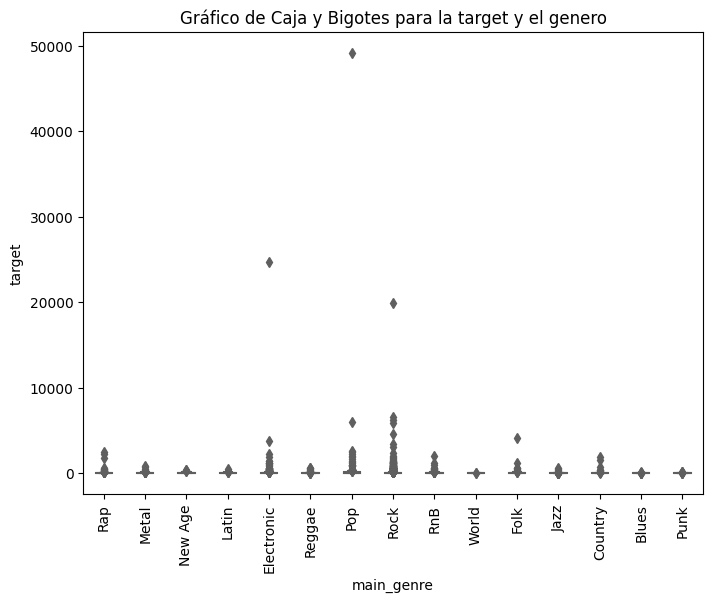

In [731]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df2, x='main_genre', y='target', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes para la target y el genero')
plt.xticks(rotation=90)
plt.show()

In [732]:
df2[df2['target'] > 10000]

,,target,main_genre,mode_confidence,end_of_fade_in,key_confidence,energy,duration,time_signature_confidence,start_of_fade_out,analysis_sample_rate_x,...,where,who,will,with,would,y,yeah,you,your,n_palabras
song_id,track_id,,,,,,,,,,,,,,,,,,,,,
SOIDDNJ12AC9071B90,TRJJCJQ12903CD2DD3,49119.0,Pop,0.475,0.125,0.544,0.0,232.69832,0.781,219.945,22050.0,...,1.0,0.0,0.0,2.0,1.0,0.0,1.0,20.0,8.0,229.0
SORBBFV12AB017D710,TRWIKPM128F931F1D2,19887.5,Rock,0.660,0.000,0.438,0.0,243.22567,0.785,236.675,22050.0,...,0.0,0.0,3.0,0.0,1.0,0.0,2.0,20.0,0.0,280.0
SOUGOHW12AB018AEA3,TRUIBLU12903CCDAD2,24681.0,Electronic,0.568,0.102,0.486,0.0,213.05424,0.927,209.096,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,110.0


In [733]:
df2 = df2[df2['target'] < 10000]

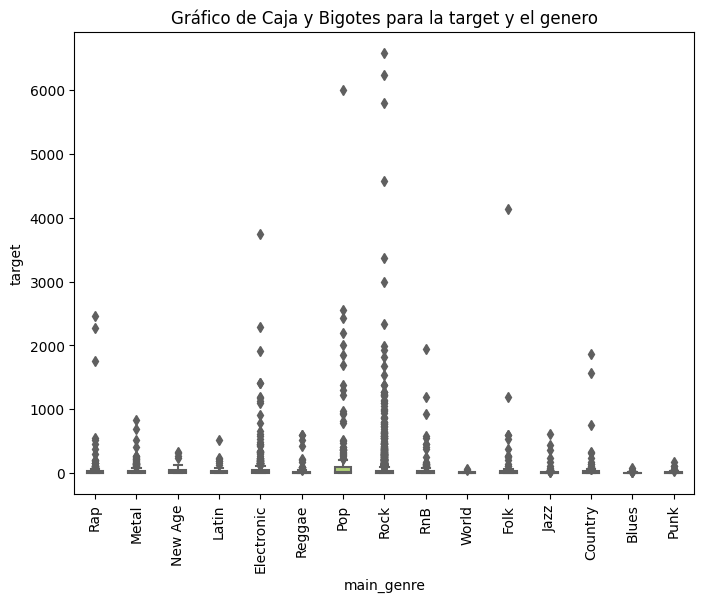

In [734]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df2, x='main_genre', y='target', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes para la target y el genero')
plt.xticks(rotation=90)
plt.show()

In [735]:
df2[df2['target'] > 2000]

,,target,main_genre,mode_confidence,end_of_fade_in,key_confidence,energy,duration,time_signature_confidence,start_of_fade_out,analysis_sample_rate_x,...,where,who,will,with,would,y,yeah,you,your,n_palabras
song_id,track_id,,,,,,,,,,,,,,,,,,,,,
SOECCQW12AC468675B,TRACDHL12903D0C387,6227.000000,Rock,0.357,0.171,0.294,0.0,189.83138,0.324,181.760,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,107.0
SOEVQQZ12A6D4F968E,TRYHBEW128F147DF6D,3746.600000,Electronic,0.553,0.107,0.389,0.0,226.53342,1.000,212.149,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,24.0
SOFPFUM12AB018AC7A,TRVGIUA12903CC5B86,2271.500000,Rap,0.335,12.928,0.505,0.0,306.02404,1.000,300.936,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOHTZUF12A8C13582B,TRKJQTO128F4249879,4576.666667,Rock,0.634,0.217,0.476,0.0,189.43955,0.699,180.407,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOIWBJU12A6701CBE7,TRUOKIQ128F14A66A5,2283.666667,Electronic,0.469,0.276,0.569,0.0,201.56036,0.702,198.298,22050.0,...,0.0,0.0,2.0,0.0,0.0,0.0,10.0,22.0,0.0,243.0
SOKKDQB12AB01883B7,TRLVJTQ12903D00EFD,2433.000000,Pop,0.378,0.165,0.204,0.0,212.27057,0.291,209.461,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOLVCKH12A8C13F5CE,TRYYWSR128F42BA8E5,2461.333333,Rap,0.502,0.067,0.386,0.0,212.24444,0.947,205.009,22050.0,...,0.0,4.0,5.0,4.0,2.0,0.0,0.0,13.0,5.0,387.0
SOMHEVM12A58A80951,TRZJGCC128F427A496,4139.500000,Folk,0.512,2.125,0.330,0.0,220.70812,1.000,206.965,22050.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,25.0
SONUEHX12AB017DB2C,TRRGTXK128F92F991B,5801.500000,Rock,0.496,0.128,0.276,0.0,213.55057,0.494,200.266,22050.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [736]:
df2= df2[df2['target'] < 2000]

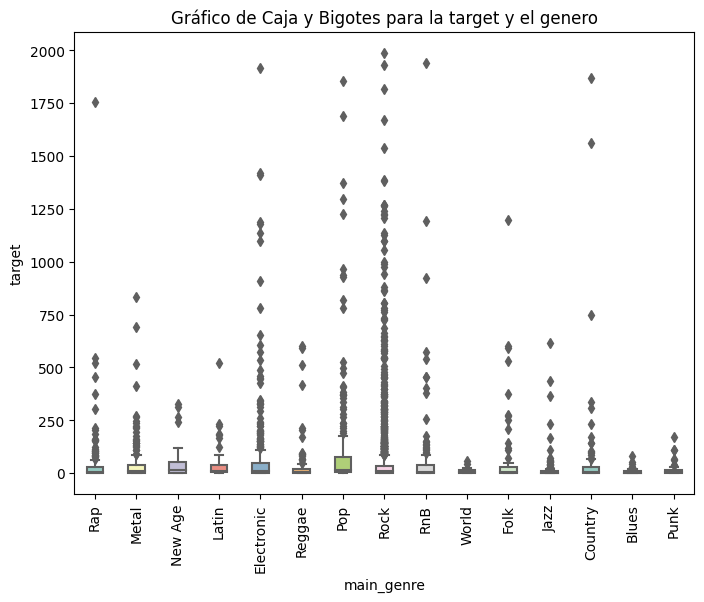

In [737]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df2, x='main_genre', y='target', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes para la target y el genero')
plt.xticks(rotation=90)
plt.show()

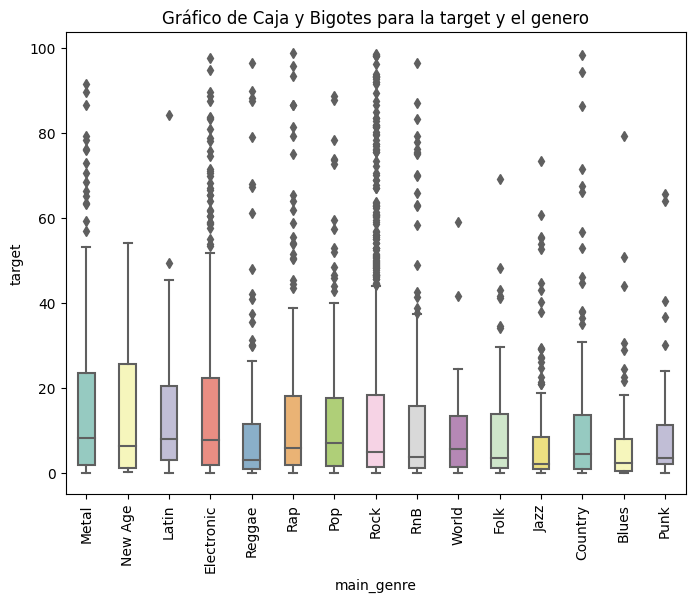

In [738]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df2[df2['target'] < 100], x='main_genre', y='target', width=0.4, palette="Set3")  
plt.title('Gráfico de Caja y Bigotes para la target y el genero')
plt.xticks(rotation=90)
plt.show()

In [739]:
df2 = pd.get_dummies(df2, columns=['main_genre'], prefix='main_genre', dtype=int)

In [740]:
X = df2.drop('target', axis = 1)
y = df2['target'] 

k = 30
seleccionador = SelectKBest(score_func=f_regression, k=k)
X_nuevo = seleccionador.fit_transform(X, y)



In [741]:
X = pd.DataFrame(X_nuevo)
X.columns = df2.drop('target',axis=1).columns[seleccionador.get_support()]

In [742]:
X

,artist_hotttnesss,loudness,length,replay_gain,sample_rate,a,and,are,come,down,...,this,to,up,we,where,will,you,your,n_palabras,main_genre_Pop
0,0.468483,-4.975,30.066916,-15.497429,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.395755,-3.094,60.081612,-14.689890,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.430942,-13.034,60.133854,-8.287628,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.387186,-8.769,30.040817,-12.303835,44100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0
4,0.468221,-8.733,30.040794,-10.047592,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,0.387899,-10.082,60.029366,-10.727055,22050.0,1.0,8.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,2.0,2.0,4.0,87.0,0.0
3306,0.387551,-9.114,30.040794,-9.330189,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3307,0.469312,-5.495,60.029366,-13.840139,22050.0,7.0,2.0,0.0,2.0,1.0,...,0.0,8.0,1.0,0.0,1.0,0.0,10.0,7.0,150.0,0.0
3308,0.387590,-14.416,60.029366,-6.319576,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


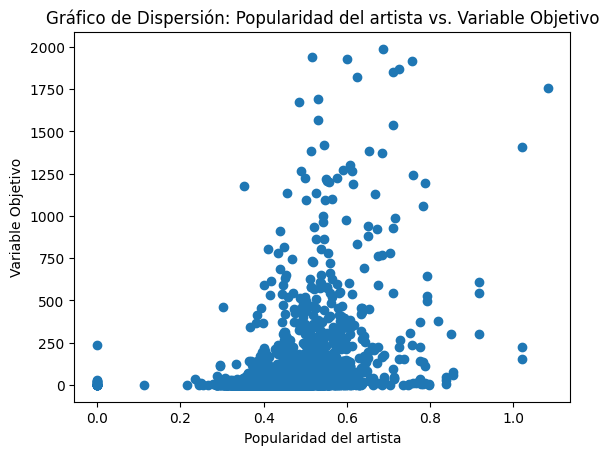

In [745]:
plt.scatter(x=X['artist_hotttnesss'], y=y)
plt.title('Gráfico de Dispersión: Popularidad del artista vs. Variable Objetivo')
plt.xlabel('Popularidad del artista')
plt.ylabel('Variable Objetivo')
plt.show()

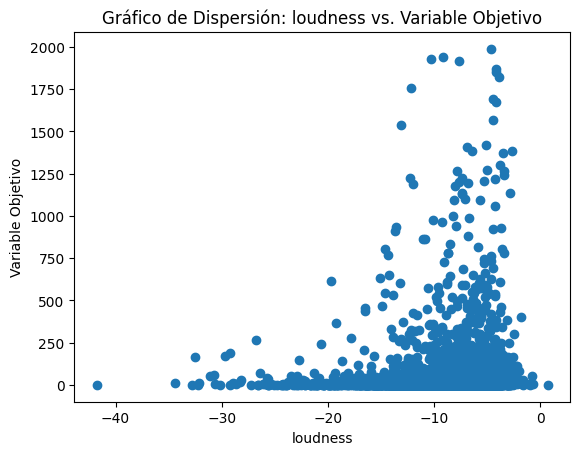

In [746]:
plt.scatter(x=X['loudness'], y=y)
plt.title('Gráfico de Dispersión: loudness vs. Variable Objetivo')
plt.xlabel('loudness')
plt.ylabel('Variable Objetivo')
plt.show()

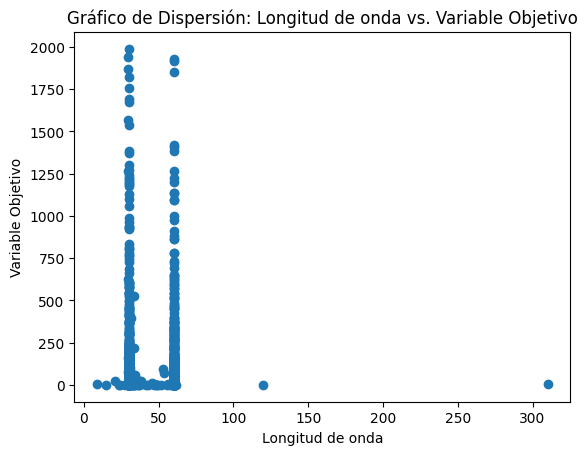

In [747]:
plt.scatter(x=X['length'], y=y)
plt.title('Gráfico de Dispersión: Longitud de onda vs. Variable Objetivo')
plt.xlabel('Longitud de onda')
plt.ylabel('Variable Objetivo')
plt.show()

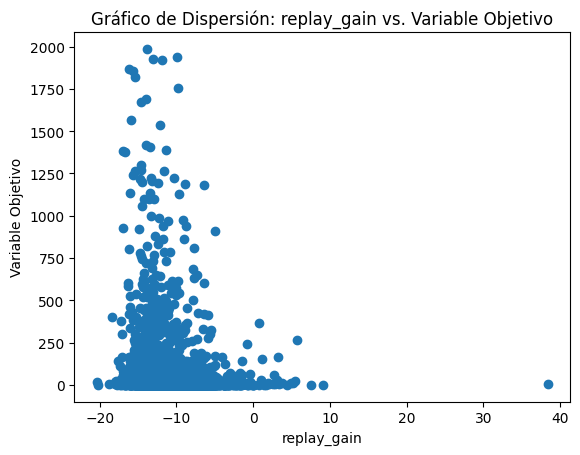

In [748]:
plt.scatter(x=X['replay_gain'], y=y)
plt.title('Gráfico de Dispersión: replay_gain vs. Variable Objetivo')
plt.xlabel('replay_gain')
plt.ylabel('Variable Objetivo')
plt.show()

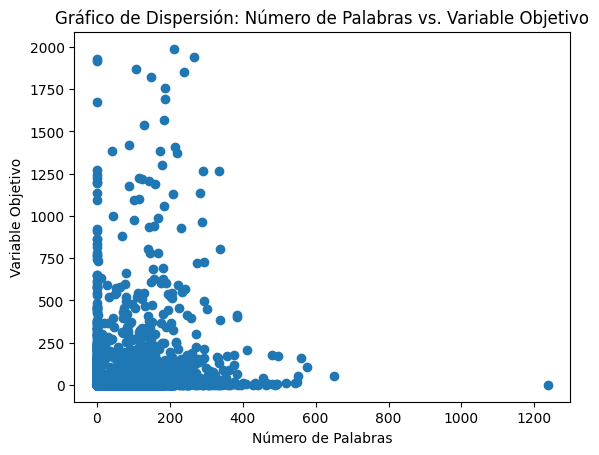

In [744]:
plt.scatter(x=X['n_palabras'], y=y)
plt.title('Gráfico de Dispersión: Número de Palabras vs. Variable Objetivo')
plt.xlabel('Número de Palabras')
plt.ylabel('Variable Objetivo')
plt.show()

In [638]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [639]:
X_train

,artist_hotttnesss,loudness,length,replay_gain,sample_rate,a,and,are,come,down,...,this,to,up,we,where,will,you,your,n_palabras,main_genre_Pop
2676,0.361822,-8.166,60.029366,-12.379723,22050.0,7.0,8.0,3.0,0.0,0.0,...,2.0,3.0,3.0,0.0,0.0,6.0,8.0,9.0,184.0,0.0
627,0.427415,-6.802,60.029366,-12.434645,22050.0,2.0,1.0,0.0,1.0,0.0,...,11.0,4.0,1.0,0.0,0.0,2.0,10.0,2.0,172.0,0.0
1340,0.390838,-9.871,60.029366,-10.943260,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1337,0.414631,-8.341,60.029366,-10.053198,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1235,0.471399,-8.236,30.066916,-10.509588,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,0.515082,-9.193,29.753447,-11.727491,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1625,0.478790,-20.644,60.029366,-6.261717,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3017,0.377806,-9.354,60.029366,-10.140268,22050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2652,0.477485,-6.921,60.081612,-6.511736,22050.0,6.0,4.0,1.0,0.0,0.0,...,0.0,6.0,2.0,0.0,1.0,5.0,3.0,0.0,161.0,0.0


In [640]:
y_test.std()

201.89975072090215

In [654]:
modelo_regresion = LinearRegression()
modelo_regresion.fit(X_train, y_train)

y_pred = modelo_regresion.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"RMSE: {rmse}")


RMSE: 188.97131095698805


In [663]:
modelo_rf = RandomForestRegressor(n_estimators=200, random_state=42) 
modelo_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [664]:
y_pred = modelo_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)

r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")

RMSE: 183.7711809353261


In [665]:
with open('regresion', 'wb') as archivo:
    pickle.dump(modelo_rf, archivo)